In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import DBSCAN
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn import preprocessing
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
import warnings  
warnings.filterwarnings('ignore')

In [2]:
# Step 0: Load the proper csvs

xtrain = pd.read_csv("X_train.csv")
xtrain = xtrain.iloc[:, 1:]
xtest = pd.read_csv("X_test.csv")
xtest = xtest.iloc[:, 1:]
ytrain = pd.read_csv("Y_train.csv")

In [3]:
# Step 1: Treat missing values
# Treat missing values as column medians. Important (apparently) to use the medians from the training set in the test set

xtrain = xtrain.fillna(xtrain.median())
xtest = xtest.fillna(xtrain.median())

In [4]:
# Step 2: Scale the training and test data

scaler = preprocessing.StandardScaler()

xtrain_scaled = scaler.fit_transform(xtrain)
xtrain = pd.DataFrame(xtrain_scaled, columns = xtrain.columns)
xtest_scaled = scaler.fit_transform(xtest)
xtest = pd.DataFrame(xtest_scaled, columns = xtest.columns)

In [5]:
# Step 3: Remove unnecessary id column from ytrain that just ***** things up

ytrain1 = ytrain.loc[:, "y"]
ytrain2 = pd.DataFrame(data = ytrain1.values, columns= ['y'])
ytrain = ytrain2

In [6]:
#reshuffling data

xtrain['y'] = ytrain
xtrain = xtrain.sample(frac=1).reset_index(drop=True)
ytrain = xtrain['y']
xtrain = xtrain.drop('y', axis = 1)

In [7]:
# Outlier detection with local outlier factor
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=700, contamination=0.1)
outliers = clf.fit_predict(xtrain)

# Remove outliers from xtrain and ytrain


outliers = outliers == 1
print(np.count_nonzero(outliers))
xtrain_ensemble = xtrain[outliers]
ytrain_ensemble = ytrain[outliers]

1090


In [8]:
'''

#Feature selection  -- cross validated inside the loop below
# option 1  
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
k_best = 500
xtrain = SelectKBest(mutual_info_regression, k=k_best).fit_transform(xtrain, ytrain)


# option 2
sel = SelectFromModel(RandomForestClassifier(n_estimators = 200))
sel.fit(xtrain, ytrain)
selected_feat = xtrain.columns[(sel.get_support())]
xtrain = xtrain.loc[:,selected_feat]
xtest = xtest.loc[:,selected_feat]
'''


'\n\n#Feature selection  -- cross validated inside the loop below\n# option 1  \nfrom sklearn.feature_selection import SelectKBest\nfrom sklearn.feature_selection import mutual_info_regression\nk_best = 500\nxtrain = SelectKBest(mutual_info_regression, k=k_best).fit_transform(xtrain, ytrain)\n\n\n# option 2\nsel = SelectFromModel(RandomForestClassifier(n_estimators = 200))\nsel.fit(xtrain, ytrain)\nselected_feat = xtrain.columns[(sel.get_support())]\nxtrain = xtrain.loc[:,selected_feat]\nxtest = xtest.loc[:,selected_feat]\n'

In [9]:
pd.DataFrame(xtrain).head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,1.586561,-1.058536,-0.745682,1.410904,-1.374616,-0.006027,-0.952789,0.756189,-1.068642,0.360884,...,-1.031899,1.256630,1.764884,1.511808,0.019453,1.018445,-0.371975,0.552479,0.788644,0.107820
1,1.431765,-0.938365,0.168690,0.276109,1.488104,1.704316,-1.627761,1.768273,-1.572117,0.772816,...,-0.646245,-1.829220,-0.070523,-0.550933,-1.596007,-1.023602,-0.190816,-0.593924,0.609220,0.107820
2,-0.111606,-1.802430,-0.060880,-1.921705,-1.835043,-0.047595,0.426401,-1.720414,1.759087,-0.276732,...,0.893634,-0.770954,-1.195993,1.981537,-1.204206,0.210436,-0.841585,1.668153,-0.031837,-1.312899
3,0.948629,-0.000953,-0.291299,0.331053,-1.618376,-0.181678,1.853890,-0.120135,-0.000429,-1.352945,...,-0.104051,-0.908278,1.733236,0.669747,-0.812145,0.872371,-0.574180,0.086262,-1.445025,-1.224886
4,0.063853,-1.312027,-0.185715,-0.015416,0.015287,0.028888,0.228571,0.010372,-0.000429,3.159222,...,0.090684,-0.051486,-0.108208,0.008415,-0.046480,-0.017560,0.046251,-0.287718,0.086689,2.991528


In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
import warnings  
warnings.filterwarnings('ignore')

folds = 10

cv_mean_scores = []
cv_stds = []
estimators = np.array([200, 300, 500])
mutual_features = np.array([50, 100, 300, 500])
alphas = np.array([0.01, 0.03, 0.1, 0.3])
max_depth = np.array([20, 25, 30])

for n in estimators:
    for best in mutual_features:
        for a in alphas: 
            for depth in max_depth: 
                
                xtrain = SelectKBest(mutual_info_regression, k = best).fit_transform(xtrain_ensemble, ytrain_ensemble)
                r1 = RandomForestRegressor(n_estimators = n, random_state = 42, max_depth = depth, bootstrap = True)
                r2 = linear_model.Lasso(alpha= a)
                r3 = xgb.XGBRegressor(objective  = "reg:squarederror", random_state = 42, n_estimators=200)
                er = VotingRegressor([('rf', r1), ('lasso', r2), ('xgb', r3)])
                scores = cross_val_score(estimator = er, X = xtrain,
                                   y = ytrain_ensemble, scoring = 'r2', cv = folds)
                cv_mean_scores.append(np.mean(scores))   
                cv_stds.append(np.std(scores))

print(cv_mean_scores)
print(cv_stds)

KeyboardInterrupt: 

0.004630794580713003

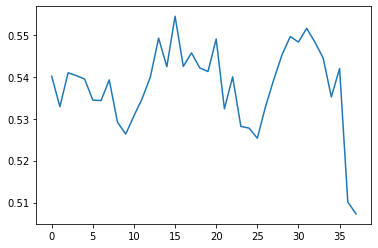

In [110]:
fig = plt.figure()
ax = plt.axes()
ax.plot(cv_mean_scores);

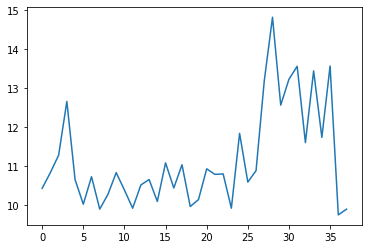

In [127]:
#plotting ratio of cv mean and cv std 

ratio = np.divide(cv_mean_scores,cv_stds)
fig = plt.figure()
ax = plt.axes()
ax.plot(ratio);


In [13]:
#ensemble model with parameters chosen by max CV above
folds = 10

xtrain = SelectKBest(mutual_info_regression, k = 100).fit_transform(xtrain_ensemble, ytrain_ensemble)
r1 = RandomForestRegressor(n_estimators = 200, random_state = 42, max_depth = 30, bootstrap = True)
r2 = linear_model.Lasso(alpha= 0.01)
r3 = xgb.XGBRegressor(objective  = "reg:squarederror", random_state = 42, n_estimators=200)
er = VotingRegressor([('rf', r1), ('lasso', r2), ('xgb', r3)])
scores = cross_val_score(estimator = er, X = xtrain,
    y = ytrain_ensemble, scoring = 'r2', cv = folds)



In [14]:
er.fit(xtrain_ensemble, ytrain_ensemble)
predict = er.predict(X = xtest)
index = pd.read_csv("sample.csv")
index['y'] = predict

index.to_csv("ensemble.csv")